In [156]:
import os
import datetime
import json
import requests
import numpy as np
import matplotlib.pyplot as plt
import rasterio

from sentinelsat import SentinelAPI, geojson_to_wkt
from azure.storage.blob import ContainerClient

In [158]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import sys

sys.path.append('/home/jovyan/data-ingestion') 
import utils.sentinel as sentineltools
import pandas as pd
import geopandas as gpd
import numpy as np
import fastparquet 
import dask.dataframe as dd
from adlfs import AzureBlobFileSystem
storage_account_name = 'cpdataeuwest'
folder_name = 'cpdata/raw/fia'

fs = AzureBlobFileSystem(account_name=storage_account_name)
parquet_files = fs.glob(folder_name + '/*parquet')
filename = 'plot'
df = dd.read_parquet(f"az://{folder_name}/{filename}.parquet",\
                     engine='fastparquet',\
                     storage_options={'account_name':storage_account_name}).compute()

#filter here for data only in sentinel range
df = df[df['MEASYEAR']>2014]
df['DATETIME'] = [pd.to_datetime(f"{int(i['MEASYEAR'])}-{int(i['MEASMON'])}-{int(i['MEASDAY'])}", format='%Y-%m-%d') for _,i in df.iterrows()]

#create the time-of-interest
df['DATERANGE'] = sentineltools.create_daterange(df)

selections = ['CN', 'INVYR', 'LAT', 'LON', 'DATETIME', 'DATERANGE']

subdf = df[selections].dropna()
gdf = gpd.GeoDataFrame(
    subdf, geometry=gpd.points_from_xy(subdf.LON, subdf.LAT))

gdf = gdf.set_crs('EPSG:4326')

buffer_distance = 6400 #buffer distance of 6400m to attain a 640x640 chip at 10m resolution
#we need to make a big enough buffer to encompass the 5km range
#ideally, we will make a chip at the largest 1400m buffer, so the largest chip will be 140x140, or 128x128
gdf = sentineltools.apply_buffer_to_points(gdf, buffer_distance)
#create the area-of-interest
gdf['AOI'] = [sentineltools.create_aoi(i['geometry']) for _,i in gdf.iterrows()]

#check the area size of the aoi
#gdf_m = gdf.to_crs("EPSG:3857")
#np.sqrt(gdf_m.area/1e06)

In [159]:
#alias the CN to UID
import random
import uuid

uid = []
cn = []
for i in range(len(gdf)):
    rnd = random.Random()
    rnd.seed(gdf.iloc[i].CN)
    u_uid = uuid.UUID(int=rnd.getrandbits(128), version=4)
    uid.append(str(u_uid))
    cn.append(gdf.iloc[i].CN)
uid = np.array([uid]).T
cn = np.array([cn]).T

linked_df = pd.DataFrame(cn, columns = ['CN'])
linked_df['UID'] = uid
gdf = pd.merge(gdf, linked_df, on='CN')

In [207]:
# This can be either a SAS token or a file with a SAS token on the file line
wd = '/home/jovyan/data-ingestion'
with open(f'{wd}/.env', 'r') as f:
    lines = f.readlines()
    for line in lines:
        key, value = line.rstrip().split(' = ')
        #value = line.rstrip().split(' = ')[1]
        os.environ[key] = value


# A text file with a login on the first line, password on the second line... basically 
# an even-less-fancy .netrc
#copernicus_credentials_file = os.path.join(os.path.expanduser('~'),'coah_username_password.txt')

sas_token = os.environ['sas_token']
username = os.environ['username']
password = os.environ['password']

In [209]:
api_url = 'https://scihub.copernicus.eu/dhus'
platform_name = 'Sentinel-1'

# Query parameters
start_time = datetime.datetime(2021,1,1,0,0,0)
end_time = datetime.datetime(2021,2,1,0,0,0)

# URL containing a geojson file with an area of interest, in this case a rectangle around Seattle
query_geojson_url = 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/stuff-near-seattle.geojson'

# Scaling constants that control rendering brightness
norm_value = 1500
composite_norm_value = 500

# When rendering whole images, how much should we downscale?
dsfactor = 10

In [212]:
storage_account_name = 'sentinel1euwest'
container_name = 's1-grd'

storage_account_url = f'https://{storage_account_name}.blob.core.windows.net/'

container_client = ContainerClient(account_url=storage_account_url, 
                                             container_name=container_name,
                                             credential=sas_token)
api = SentinelAPI(user=username, password=password, api_url=api_url)

In [214]:
#geojson = json.loads(requests.get(query_geojson_url).text)
geojson = gdf.iloc[100]['AOI']
footprint = geojson_to_wkt(geojson)

products = api.query(footprint,
                     producttype='GRD',
                     date=(start_time,end_time),
                     platformname=platform_name)

In [217]:
product_values = list(products.values())
    
print('Found {} tiles:'.format(len(products)))
for p in product_values:
    print(p['filename'])
product = product_values[0]
import pprint; pp = pprint.PrettyPrinter(indent=2)
pp.pprint(product)

Found 5 tiles:
S1A_IW_GRDH_1SDV_20210126T234627_20210126T234652_036316_0442D0_5068.SAFE
S1A_IW_GRDH_1SDV_20210121T233806_20210121T233831_036243_04404F_C144.SAFE
S1A_IW_GRDH_1SDV_20210114T234628_20210114T234653_036141_043CBD_6B01.SAFE
S1A_IW_GRDH_1SDV_20210109T233807_20210109T233832_036068_043A33_4655.SAFE
S1A_IW_GRDH_1SDV_20210102T234628_20210102T234653_035966_043695_8125.SAFE
{ 'acquisitiontype': 'NOMINAL',
  'beginposition': datetime.datetime(2021, 1, 26, 23, 46, 27, 968000),
  'endposition': datetime.datetime(2021, 1, 26, 23, 46, 52, 967000),
  'filename': 'S1A_IW_GRDH_1SDV_20210126T234627_20210126T234652_036316_0442D0_5068.SAFE',
  'footprint': 'MULTIPOLYGON (((-87.444839 31.57588, -84.79995 31.981291, '
               '-85.099167 33.484936, -87.788971 33.081795, -87.444839 '
               '31.57588)))',
  'format': 'SAFE',
  'gmlfootprint': '<gml:Polygon '
                  'srsName="http://www.opengis.net/gml/srs/epsg.xml#4326" '
                  'xmlns:gml="http://www.opengis.

In [219]:
# For the product:
#
# S1B_IW_GRDH_1SDV_20210129T020125_20210129T020150_025363_030553_F429.SAFE
#    
# Our path is:
#    
# https://sentinel1euwest.blob.core.windows.net/s1-grd/
#
# GRD/2021/1/29/IW/DV/S1B_IW_GRDH_1SDV_20210129T020125_20210129T020150_025363_030553_F429/
#
# Everything here can be pulled directly from the scene name, we don't actually need the product
# metadata.

root = 'GRD'
f = product['filename']

def copernicus_to_azure(filename):
    scene_name = filename.replace('.SAFE','')
    mode = scene_name[4:6]
    polarization = scene_name[14:16] # "DV", for example, is "dual VV/VH"
    year = scene_name[17:21];
    month = scene_name[21:23].lstrip('0');
    day = scene_name[23:25].lstrip('0');
    azure_scene_prefix = '/'.join([root,year,month,day,mode,polarization,scene_name])
    return azure_scene_prefix

azure_scene_prefix = copernicus_to_azure(f)

print('Azure scene prefix: {}'.format(azure_scene_prefix))

Azure scene prefix: GRD/2021/1/26/IW/DV/S1A_IW_GRDH_1SDV_20210126T234627_20210126T234652_036316_0442D0_5068


In [220]:
generator = container_client.list_blobs(name_starts_with=azure_scene_prefix)
scene_files = list(generator)
image_blobs = [blob.name for blob in scene_files if blob.name.endswith('.tiff')]
preview_blobs = [blob.name for blob in scene_files if blob.name.endswith('quick-look.png')]

print('Found {} image files and {} preview files:'.format(len(image_blobs),len(preview_blobs)))
for s in image_blobs:
    print(s)
for s in preview_blobs:
    print(s)

Found 2 image files and 1 preview files:
GRD/2021/1/26/IW/DV/S1A_IW_GRDH_1SDV_20210126T234627_20210126T234652_036316_0442D0_5068/measurement/iw-vh.tiff
GRD/2021/1/26/IW/DV/S1A_IW_GRDH_1SDV_20210126T234627_20210126T234652_036316_0442D0_5068/measurement/iw-vv.tiff
GRD/2021/1/26/IW/DV/S1A_IW_GRDH_1SDV_20210126T234627_20210126T234652_036316_0442D0_5068/preview/quick-look.png


In [151]:
image_urls = []
for blob_path in image_blobs:
    image_urls.append(storage_account_url + container_name + '/' + blob_path + sas_token)
preview_urls = []
for blob_path in preview_blobs:
    preview_urls.append(storage_account_url + container_name + '/' + blob_path + sas_token)

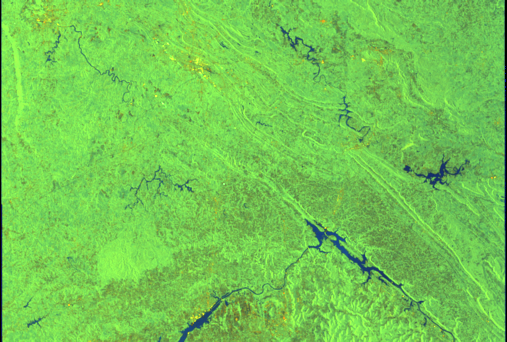

In [152]:
from PIL import Image
from IPython.display import display
import requests
import io

url = preview_urls[0]
response = requests.get(url)
image_bytes = io.BytesIO(response.content)
img = Image.open(image_bytes)
display(img)

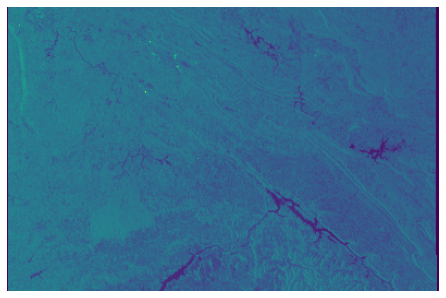

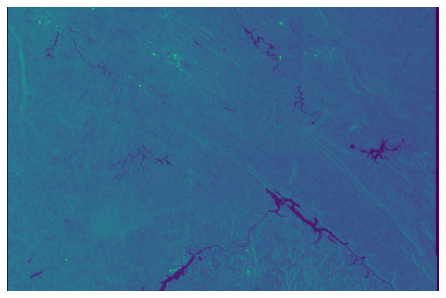

In [153]:
for url in image_urls:
    
    with rasterio.open(url) as raster:
        
        # List of overviews from biggest to smallest
        oviews = raster.overviews(1)
    
        # Retrieve the smallest thumbnail
        decimation_level = oviews[-1]
        h = int(raster.height/decimation_level)
        w = int(raster.width/decimation_level)
        
        d = raster.read(1, out_shape=(1, h, w)) / norm_value
        np.clip(d,0,1,d)
        fig = plt.figure(frameon=False); ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)
        plt.imshow(d)

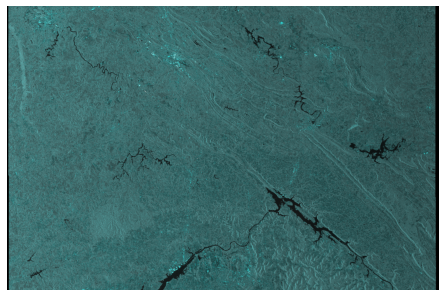

In [154]:
image_data = []

for url in image_urls:
    with rasterio.open(url,'r') as raster:
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        band_array = raster.read(1, out_shape=(1, h, w))
        raster.close()
        band_array = band_array / composite_norm_value
        image_data.append(band_array)

# Lazily re-use the last capture to make an RGB image        
while len(image_data) < 3:
    image_data.append(image_data[-1])
rgb = np.dstack((image_data[0],image_data[1],image_data[2]))

np.clip(rgb,0,1,rgb)
fig = plt.figure(frameon=False); ax = plt.Axes(fig,[0., 0., 1., 1.]); ax.set_axis_off(); fig.add_axes(ax)                
plt.imshow(rgb);